In [1]:
%matplotlib inline
# import librosa
# import librosa.display
import torch
import torchaudio
from torchaudio import transforms
from matplotlib import pyplot as plt
import numpy as np
import glob
import random
from exp.nb_SparseImageWarp import sparse_image_warp

In [2]:
data = glob.glob("data/train/*.wav")

In [128]:
y,sr = torchaudio.load(data[0])
mel = transforms.MelSpectrogram(sr,n_fft=512)(y)
mel = mel.transpose(1,2)
mel = transforms.AmplitudeToDB(stype="magnitude",top_db=80)(mel)

In [129]:
print(y.shape,mel.shape)

torch.Size([1, 73120]) torch.Size([1, 286, 128])


In [130]:
def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    device = spec.device
    
    y = num_rows//2
    horizontal_line_at_ctr = spec[0][y]
    assert len(horizontal_line_at_ctr) == spec_len
    
    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]
    assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts, dest_pts = (torch.tensor([[[y, point_to_warp]]], device=device), 
                         torch.tensor([[[y, point_to_warp + dist_to_warp]]], device=device))
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)
def freq_mask(spec, F=30, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned
def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned

In [147]:
test = time_mask(freq_mask(time_warp(mel), num_masks=1), num_masks=1)

In [148]:
test.shape

torch.Size([1, 286, 128])

In [149]:
def tensor_to_img(spectrogram):
    plt.figure(figsize=(10,5)) # arbitrary, looks good on my screen.
    plt.imshow(spectrogram[0])
    plt.show();
    display(spectrogram.shape)

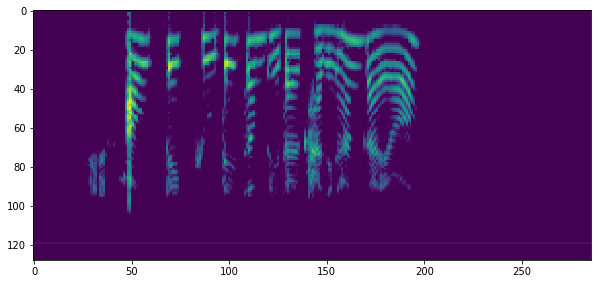

torch.Size([1, 128, 286])

In [150]:
tensor_to_img(test.detach().transpose(1,2))

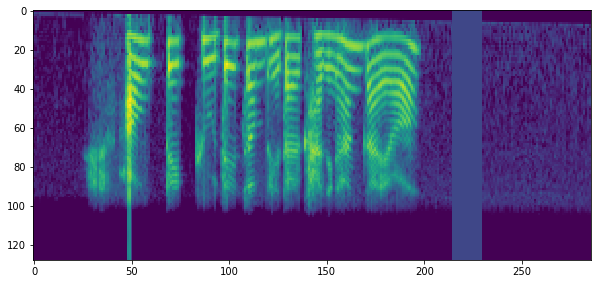

torch.Size([1, 128, 286])

In [127]:
tensor_to_img(test.detach().transpose(1,2))

In [120]:
test.mean()

tensor(-21.9107, grad_fn=<MeanBackward0>)

In [3]:
y,sr = librosa.load(data[1])

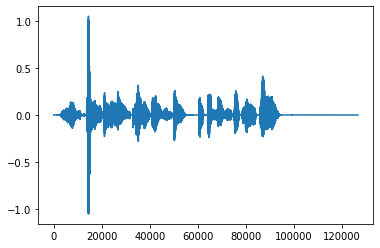

In [4]:
plt.plot(y)

In [5]:
frame_length = 0.025
frame_stride = 0.010

In [6]:
from specAugment import spec_augment_tensorflow

In [24]:
def Mel_S(wav):
    y, sr = librosa.load(wav)
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, n_mels=256, hop_length=128, fmax=8000)
    masked = spec_augment_tensorflow.spec_augment(mel_spectrogram=S, time_warping_para=20, frequency_masking_para=50, time_masking_para=100)
    print("Wav length: {}, Mel_S shape:{}".format(len(y)/sr,np.shape(S)))
    
    plt.figure(figsize=(10,5))
    librosa.display.specshow(librosa.power_to_db(masked, ref=np.max), y_axis='mel', sr=sr, hop_length=128, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.tight_layout()
    plt.show()
    return masked

Wav length: 4.570022675736961, Mel_S shape:(256, 788)


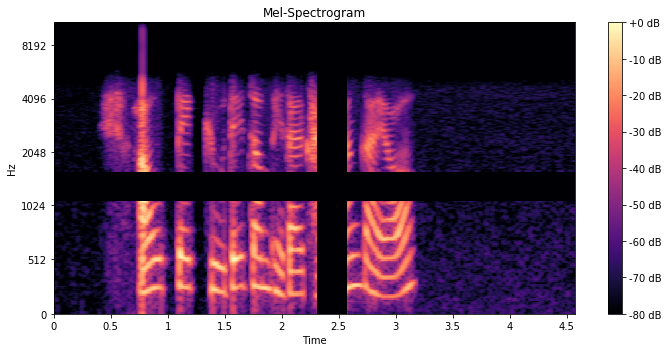

In [25]:
mel = Mel_S(data[0])

In [8]:
def Stft(wav):
    y, sr = librosa.load(wav)
    S, phase = librosa.magphase(librosa.stft(y,n_fft=512))
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                             y_axis='log', x_axis='time', sr=sr)
    plt.colorbar()
    plt.tight_layout()
    return librosa.amplitude_to_db(S, ref=np.max)

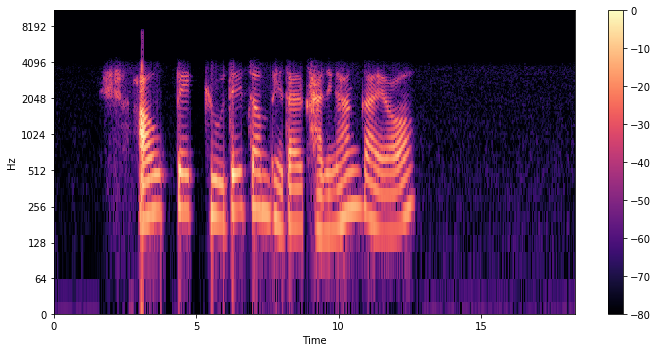

In [9]:
st = Stft(data[0])

In [10]:
st.shape

(257, 788)

In [11]:
np.max(st)

0.0

(array([1.3705e+05, 1.8020e+03, 1.9050e+03, 2.0780e+03, 2.0000e+03,
        2.0870e+03, 2.2100e+03, 2.2290e+03, 2.1870e+03, 2.1120e+03,
        2.0790e+03, 1.9340e+03, 1.7260e+03, 1.6300e+03, 1.5430e+03,
        1.4460e+03, 1.2300e+03, 1.2090e+03, 1.0200e+03, 1.0980e+03,
        1.0280e+03, 9.2900e+02, 9.3500e+02, 9.1600e+02, 8.7600e+02,
        8.7200e+02, 7.7700e+02, 8.3200e+02, 8.1300e+02, 7.6600e+02,
        7.7600e+02, 6.9200e+02, 6.8600e+02, 6.4900e+02, 6.5200e+02,
        7.0000e+02, 6.3400e+02, 6.1700e+02, 6.4200e+02, 6.4100e+02,
        6.3600e+02, 6.1400e+02, 5.9100e+02, 5.5600e+02, 6.3700e+02,
        6.1700e+02, 5.9200e+02, 5.5900e+02, 5.9500e+02, 5.4400e+02,
        5.2100e+02, 5.5500e+02, 5.1800e+02, 4.9000e+02, 4.9700e+02,
        4.6700e+02, 4.5600e+02, 4.1600e+02, 3.9000e+02, 4.2100e+02,
        3.7400e+02, 3.7300e+02, 3.8500e+02, 3.1800e+02, 2.8400e+02,
        2.6800e+02, 2.8500e+02, 2.9600e+02, 2.3200e+02, 2.7400e+02,
        2.5900e+02, 2.4800e+02, 2.2700e+02, 2.33

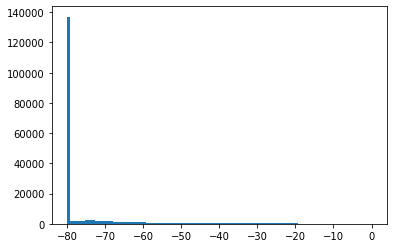

In [12]:
x = []
for i in st:
    for j in i:
        x.append(j)
plt.hist(x,bins=100)

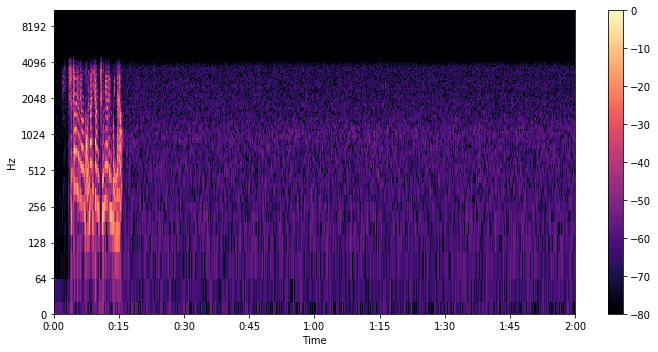

In [13]:
st = Stft(data[76])

In [14]:
st.shape

(257, 5168)

In [15]:
np.max(st)

0.0

In [47]:
def Mfcc(wav):
    y, sr = librosa.load(wav)
    plt.plot(y)
    plt.show()
    mf = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, n_fft=2048, n_mels=256, hop_length=128, fmax=8000)
    plt.figure(figsize=(10,5))
    librosa.display.specshow(librosa.amplitude_to_db(mf), x_axis="time")
    plt.colorbar()
    plt.title("MFCC")
    plt.tight_layout()
    plt.show()
    return mf

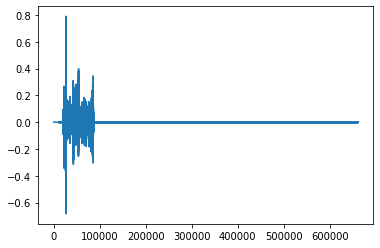

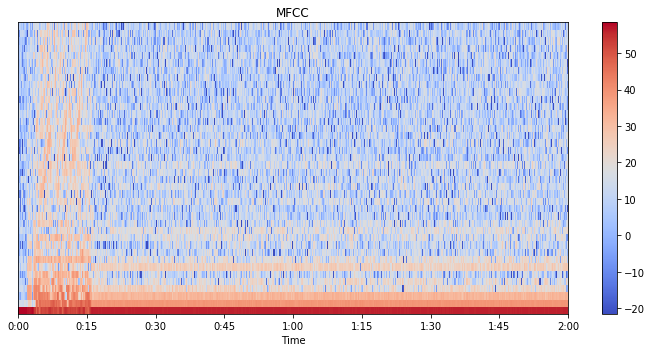

In [48]:
mfcc = Mfcc(data[76])

In [42]:
mfcc.shape

(40, 1292)